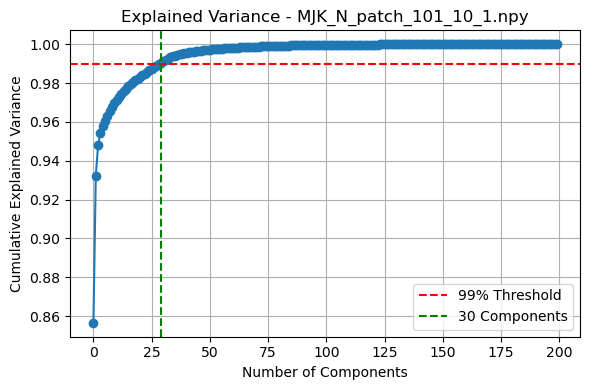

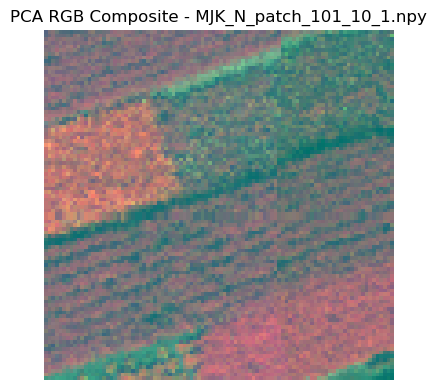

PCA transformed data shape: (96, 96, 30)


In [11]:
import numpy as np
import os
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


file_path = r'C:\Users\raaya\Downloads\Test\rs\MJK_N_patch_101_10_1.npy'
output_dir = r'C:\Users\raaya\OneDrive\Desktop\Hyperspectular\Assignment'
explained_threshold = 0.99

os.makedirs(output_dir, exist_ok=True)

data = np.load(file_path)  # Shape: (H, W, B)
h, w, b = data.shape
data_reshaped = data.reshape(-1, b)  # Shape: (H*W, B)

pca_full = PCA()
pca_full.fit(data_reshaped)

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components = np.searchsorted(cumulative_variance, explained_threshold) + 1

pca = PCA(n_components=n_components)
transformed = pca.fit_transform(data_reshaped)
transformed_reshaped = transformed.reshape(h, w, n_components)
filename = os.path.basename(file_path)
save_path = os.path.join(output_dir, filename)
np.save(save_path, transformed_reshaped)


plt.figure(figsize=(6, 4))
plt.plot(cumulative_variance, marker='o')
plt.axhline(y=explained_threshold, color='r', linestyle='--', label=f'{explained_threshold*100:.0f}% Threshold')
plt.axvline(x=n_components-1, color='g', linestyle='--', label=f'{n_components} Components')
plt.title(f'Explained Variance - {filename}')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

if n_components >= 3:
    rgb = transformed_reshaped[:, :, :3]
    rgb_norm = (rgb - rgb.min()) / (rgb.max() - rgb.min())  # Normalize to 0–1

    plt.figure(figsize=(4, 4))
    plt.imshow(rgb_norm)
    plt.title(f'PCA RGB Composite - {filename}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

print(f"PCA transformed data shape: {transformed_reshaped.shape}")


Running 10000 pixel purity iterations...  0.Running 10000 pixel purity iterations...  0.Running 10000 pixel purity iterations...  0.Running 10000 pixel purity iterations...  0.Running 10000 pixel purity iterations...  0.Running 10000 pixel purity iterations...  0.Running 10000 pixel purity iterations...  0.Running 10000 pixel purity iterations...  0.Running 10000 pixel purity iterations...  0.Running 10000 pixel purity iterations...  0.Running 10000 pixel purity iterations...  1.Running 10000 pixel purity iterations...  1.Running 10000 pixel purity iterations...  1.Running 10000 pixel purity iterations...  1.Running 10000 pixel purity iterations...  1.Running 10000 pixel purity iterations...  1.Running 10000 pixel purity iterations...  1.Running 10000 pixel purity iterations...  1.Running 10000 pixel purity iterations...  1.Running 10000 pixel purity iterations...  1.Running 10000 pixel purity iterations...  2.Running 10000 pixel purity iterations...  2.Running 10000 pixel purity itera

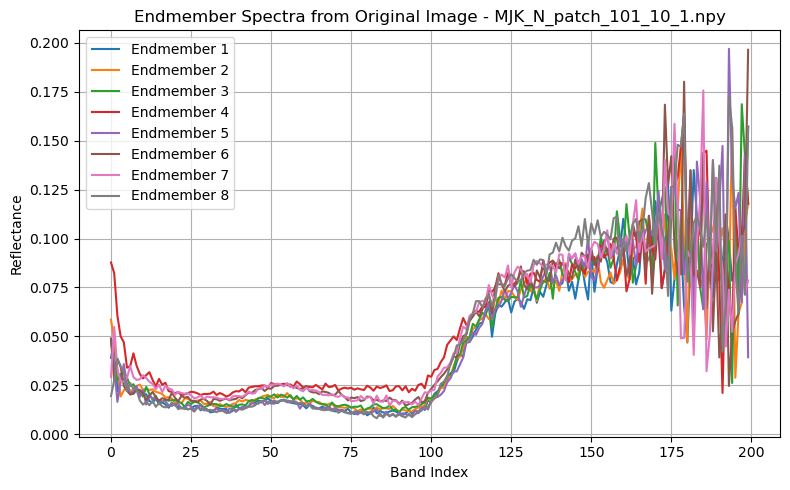

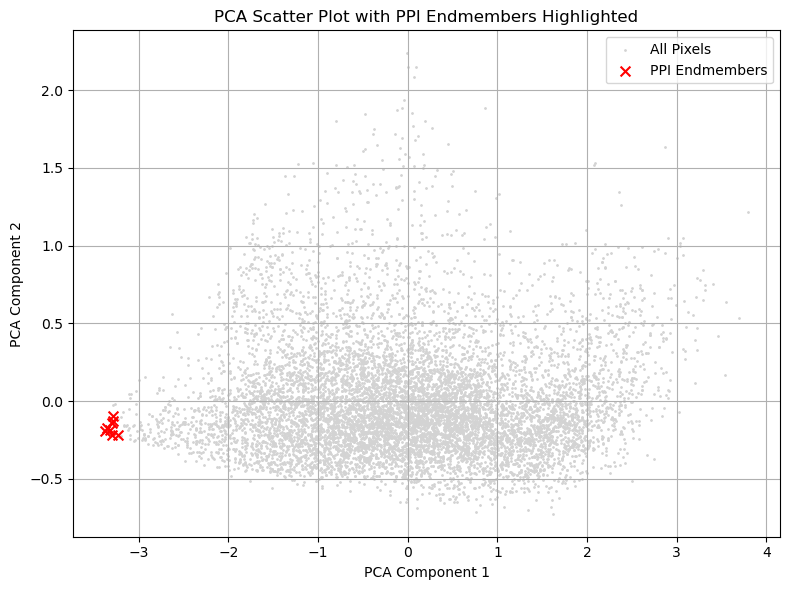

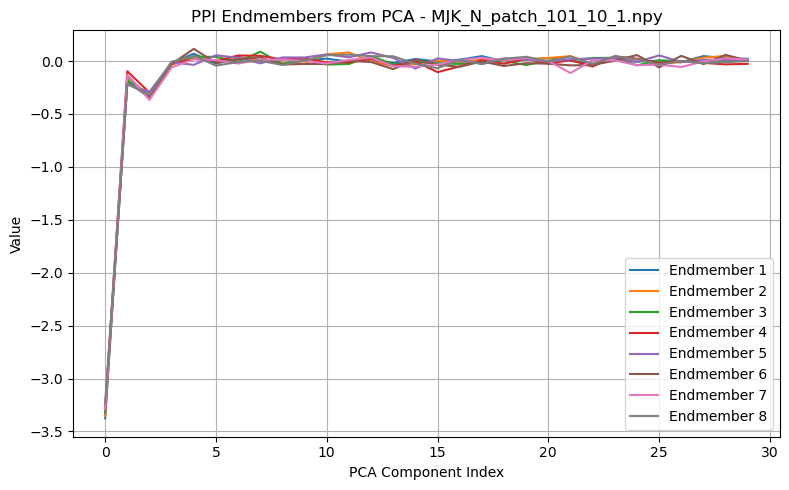

In [6]:
import numpy as np
import os
from spectral.algorithms import ppi
import matplotlib.pyplot as plt

# Paths
pca_file_path = r'C:\Users\raaya\OneDrive\Desktop\Hyperspectular\Assignment\MJK_N_patch_101_10_1.npy'
original_file_path = r'C:\Users\raaya\Downloads\Test\rs\MJK_N_patch_101_10_1.npy'
ppi_output_dir = r'C:\Users\raaya\OneDrive\Desktop\Hyperspectular\Assignment\ppi_endmembers'
os.makedirs(ppi_output_dir, exist_ok=True)

# Parameters
n_endmembers = 8
num_projections = 10000
ppi_threshold = 0.12

# Load data
pca_data = np.load(pca_file_path)        # Shape: (h, w, c_PCA)
original_data = np.load(original_file_path)  # Shape: (h, w, c_original)

h, w, c = pca_data.shape

# Perform PPI
ppi_counts = ppi(pca_data, niters=num_projections, threshold=ppi_threshold)
flat_indices = np.argsort(ppi_counts.ravel())[::-1][:n_endmembers]
row_indices, col_indices = np.unravel_index(flat_indices, (h, w))

# Extract endmembers
ppi_endmembers_pca = np.array([pca_data[r, c, :] for r, c in zip(row_indices, col_indices)])
ppi_endmembers_original = np.array([original_data[r, c, :] for r, c in zip(row_indices, col_indices)])

# Save endmembers (original space)
filename = os.path.basename(pca_file_path)
save_path = os.path.join(ppi_output_dir, filename.replace('.npy', '_ppi_endmembers_original.npy'))
np.save(save_path, ppi_endmembers_original)

print(f"{filename}: Extracted {ppi_endmembers_original.shape[0]} endmembers from original image data")

# -------------------------------------
# Plot 1: Endmember spectra (Original)
# -------------------------------------
plt.figure(figsize=(8, 5))
for i, spectrum in enumerate(ppi_endmembers_original):
    plt.plot(spectrum, label=f'Endmember {i+1}')
plt.title(f'Endmember Spectra from Original Image - {filename}')
plt.xlabel('Band Index')  # Use 'Wavelength (nm)' if you have spectral info
plt.ylabel('Reflectance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------------------------
# Plot 2: PCA Scatter Plot + Highlight Endmembers
# ------------------------------------------------
pixels_2d = pca_data.reshape(-1, c)[:, :2]  # Only first 2 PCA components
endmember_flat_indices = row_indices * w + col_indices

plt.figure(figsize=(8, 6))
plt.scatter(pixels_2d[:, 0], pixels_2d[:, 1], s=1, color='lightgray', label='All Pixels')
plt.scatter(pixels_2d[endmember_flat_indices, 0], pixels_2d[endmember_flat_indices, 1],
            color='red', s=50, marker='x', label='PPI Endmembers')

plt.title('PCA Scatter Plot with PPI Endmembers Highlighted')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot endmembers
plt.figure(figsize=(8, 5))
for i, spectrum in enumerate(ppi_endmembers_pca):
    plt.plot(spectrum, label=f'Endmember {i+1}')
plt.title(f'PPI Endmembers from PCA - {filename}')
plt.xlabel('PCA Component Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

MJK_N_patch_101_10_1.npy: Extracted 8 endmembers via VCA on PCA data


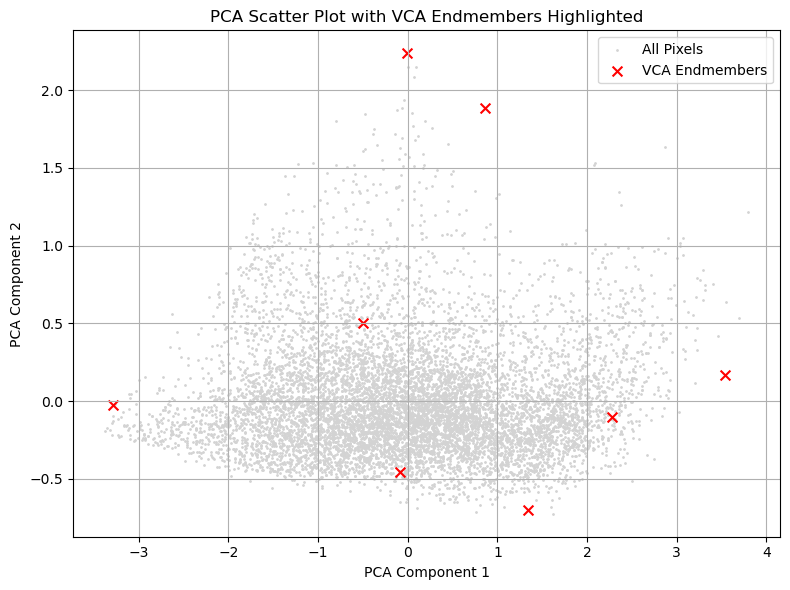

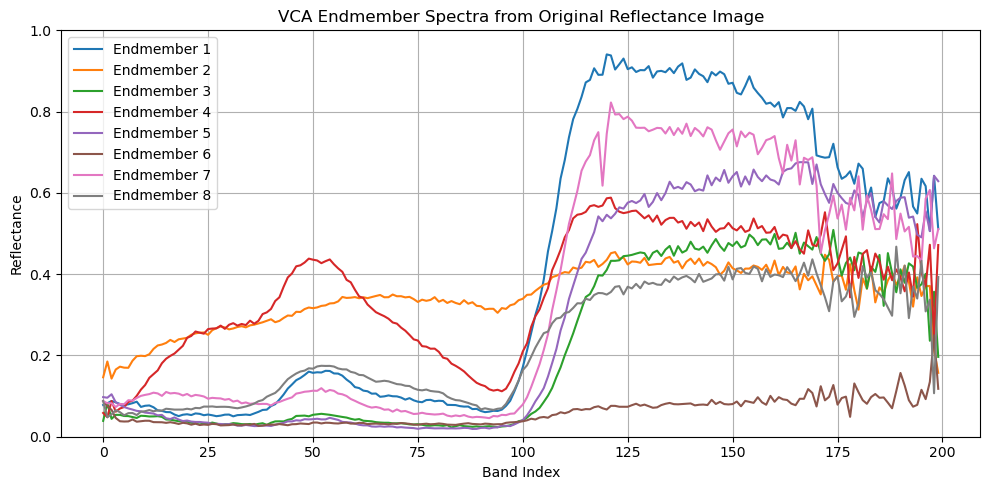

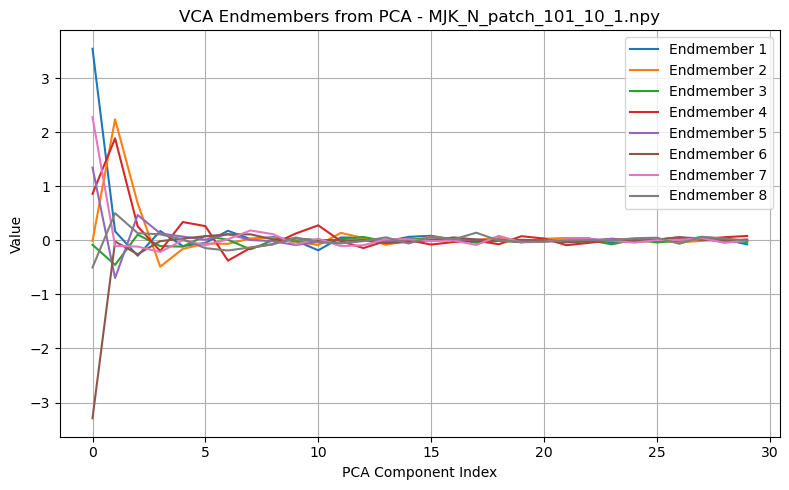

In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt

def vca(Y, num_endmembers):
    L, N = Y.shape
    Ud, S, _ = np.linalg.svd(np.dot(Y, Y.T) / N)
    Ud = Ud[:, :num_endmembers]
    x_p = np.dot(Ud.T, Y)
    x_p = np.vstack((x_p, np.ones((1, N))))
    
    E = np.zeros((L, num_endmembers))
    A = np.zeros((num_endmembers + 1, num_endmembers))
    
    for i in range(num_endmembers):
        w = np.random.randn(num_endmembers + 1)
        f = w - np.dot(A, np.dot(np.linalg.pinv(A), w))
        f = f / np.linalg.norm(f)
        v = np.dot(f.T, x_p)
        ind = np.argmax(np.abs(v))
        E[:, i] = Y[:, ind]
        A[:, i] = x_p[:, ind]
    return E

# ===== Load PCA-reduced data =====
pca_file_path = r'C:\Users\raaya\OneDrive\Desktop\Hyperspectular\Assignment\MJK_N_patch_101_10_1.npy'
output_dir = r'C:\Users\raaya\OneDrive\Desktop\Hyperspectular\Assignment\vca_endmember'
os.makedirs(output_dir, exist_ok=True)

num_endmembers = 8

data = np.load(pca_file_path)
h, w, c = data.shape

data_reshaped = data.reshape(-1, c).T  # shape: (c, h*w)

# Run VCA
endmembers = vca(data_reshaped, num_endmembers)

# Save endmembers
filename = os.path.basename(pca_file_path)
save_path = os.path.join(output_dir, filename.replace('.npy', '_vca_endmembers.npy'))
np.save(save_path, endmembers)

print(f"{filename}: Extracted {num_endmembers} endmembers via VCA on PCA data")

# Find spatial locations of endmembers by matching spectra
pixels = data.reshape(-1, c)

vca_endmember_locations = []
for i in range(num_endmembers):
    spectrum = endmembers[:, i]
    distances = np.linalg.norm(pixels - spectrum, axis=1)
    closest_pixel_idx = np.argmin(distances)
    vca_endmember_locations.append(closest_pixel_idx)

vca_endmember_locations = np.array(vca_endmember_locations)

vca_row_indices, vca_col_indices = np.unravel_index(vca_endmember_locations, (h, w))

# ===== Plot 1: PCA scatter plot with VCA endmembers highlighted =====
plt.figure(figsize=(8, 6))
plt.scatter(pixels[:, 0], pixels[:, 1], s=1, color='lightgray', label='All Pixels')
plt.scatter(pixels[vca_endmember_locations, 0], pixels[vca_endmember_locations, 1],
            color='red', s=50, marker='x', label='VCA Endmembers')
plt.title('PCA Scatter Plot with VCA Endmembers Highlighted')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ===== Plot 2: Endmember reflectance spectra from original image =====
original_file_path = r'C:\Users\raaya\Downloads\Test\rs\MJK_N_patch_101_10_1.npy'
original_image = np.load(original_file_path)  # shape: (96, 96, 200)

vca_endmember_reflectance = np.array([
    original_image[r, c, :] for r, c in zip(vca_row_indices, vca_col_indices)
])

plt.figure(figsize=(10, 5))
for i, spectrum in enumerate(vca_endmember_reflectance):
    plt.plot(spectrum, label=f'Endmember {i+1}')
plt.title('VCA Endmember Spectra from Original Reflectance Image')
plt.xlabel('Band Index')
plt.ylabel('Reflectance')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot endmembers spectra
plt.figure(figsize=(8, 5))
for i in range(num_endmembers):
    plt.plot(endmembers[:, i], label=f'Endmember {i+1}')
plt.title(f'VCA Endmembers from PCA - {filename}')
plt.xlabel('PCA Component Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

MJK_N_patch_101_10_1.npy: Extracted 8 endmembers via N-FINDR on PCA-reduced data


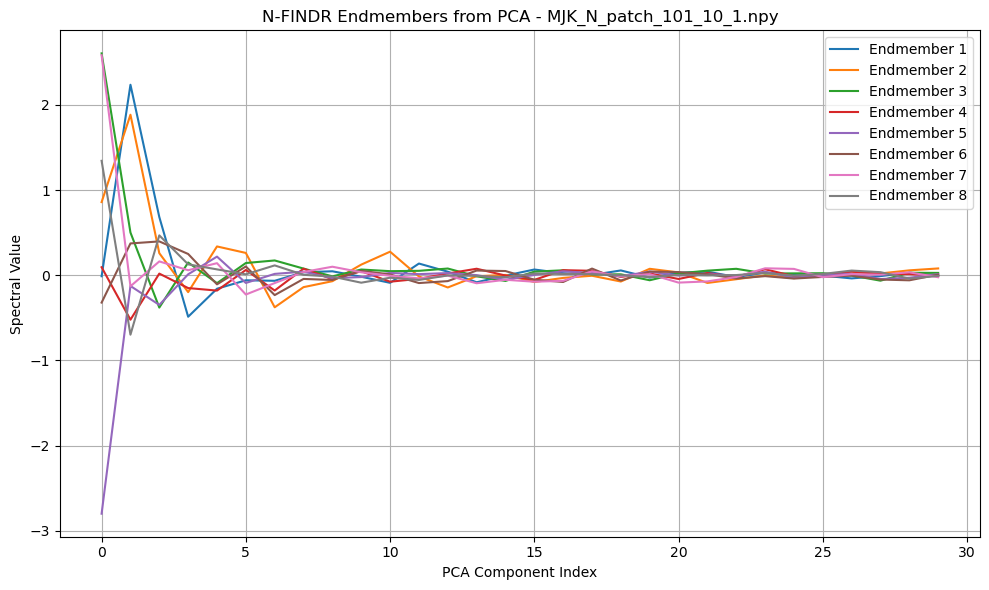

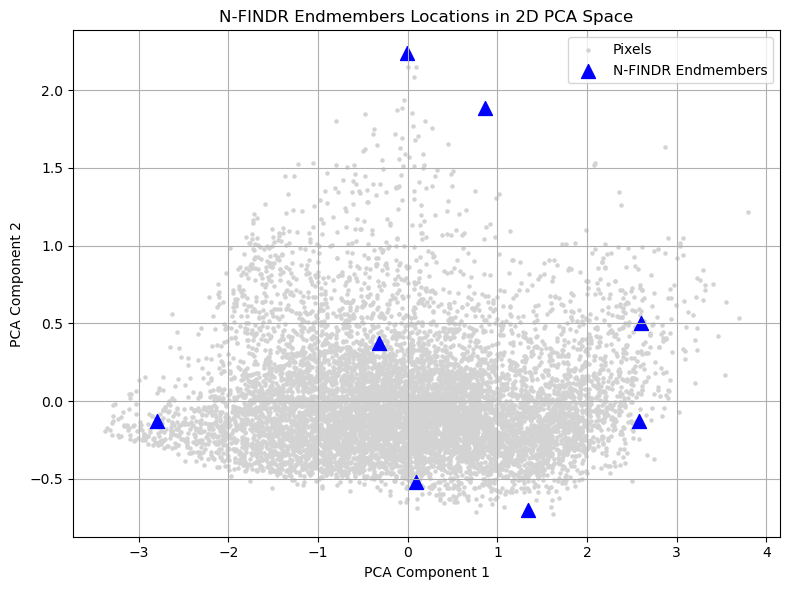

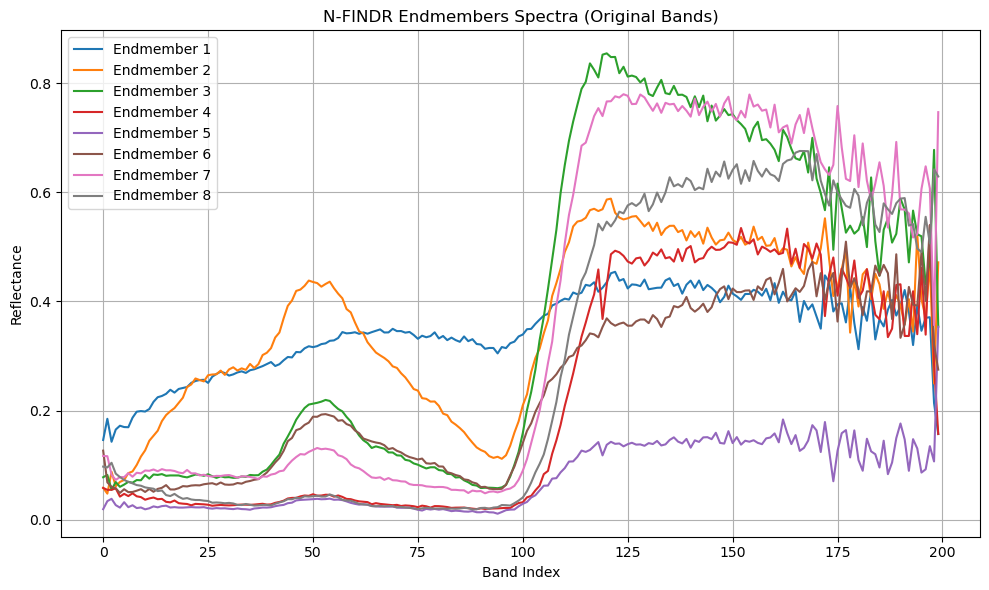

In [5]:
import numpy as np
import os
import math
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

def compute_simplex_volume(matrix):
    matrix_centered = matrix - matrix[:, [0]]
    try:
        Q, R = np.linalg.qr(matrix_centered[:, 1:].T)
        volume = np.abs(np.prod(np.diag(R))) / math.factorial(matrix.shape[1] - 1)
    except np.linalg.LinAlgError:
        volume = 0
    return volume

def nfindr(data, num_endmembers, max_iter=5):
    num_components, num_pixels = data.shape
    indices = np.random.choice(num_pixels, num_endmembers, replace=False)
    endmembers = data[:, indices]

    for _ in range(max_iter):
        for i in range(num_endmembers):
            for j in range(num_pixels):
                test_endmembers = endmembers.copy()
                test_endmembers[:, i] = data[:, j]
                if compute_simplex_volume(test_endmembers) > compute_simplex_volume(endmembers):
                    endmembers[:, i] = data[:, j]
    return endmembers

# === File paths ===
pca_file_path = r'C:\Users\raaya\OneDrive\Desktop\Hyperspectular\Assignment\MJK_N_patch_101_10_1.npy'
original_file_path = r'C:\Users\raaya\Downloads\Test\rs\MJK_N_patch_101_10_1.npy'
output_dir = r'C:\Users\raaya\OneDrive\Desktop\Hyperspectular\Assignment\NFinder_endmember'
os.makedirs(output_dir, exist_ok=True)

n_endmembers = 8

# === Load PCA-reduced data (H, W, n_components) ===
data = np.load(pca_file_path)
h, w, c = data.shape

if n_endmembers > c:
    raise ValueError(f"n_endmembers ({n_endmembers}) cannot be greater than PCA components ({c})")

# Reshape for N-FINDR input: (components, pixels)
data_2d = data.reshape(-1, c).T  # shape: (c, h*w)

# Extract endmembers using N-FINDR
endmembers = nfindr(data_2d, n_endmembers)

# Save extracted endmembers (transpose back to pixels x bands/components)
filename = os.path.basename(pca_file_path)
save_path = os.path.join(output_dir, filename.replace('.npy', '_nfindr_endmembers.npy'))
np.save(save_path, endmembers.T)

print(f"{filename}: Extracted {endmembers.shape[1]} endmembers via N-FINDR on PCA-reduced data")

# === Plot endmember spectra in PCA space ===
plt.figure(figsize=(10, 6))
for i, spectrum in enumerate(endmembers.T):
    plt.plot(spectrum, label=f'Endmember {i+1}')
plt.title(f'N-FINDR Endmembers from PCA - {filename}')
plt.xlabel('PCA Component Index')
plt.ylabel('Spectral Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Scatter plot in 2D PCA space ===
pixels_2d = data[:, :, :2].reshape(-1, 2)  # shape: (h*w, 2)
reshaped_pixels = data_2d.T  # shape: (h*w, c)

nearest_indices = []
for i in range(n_endmembers):
    spectrum = endmembers[:, i].reshape(1, -1)
    distances = cdist(spectrum, reshaped_pixels)
    nearest_idx = np.argmin(distances)
    nearest_indices.append(nearest_idx)

nearest_indices = np.array(nearest_indices)
endmember_coords = pixels_2d[nearest_indices]

plt.figure(figsize=(8, 6))
plt.scatter(pixels_2d[:, 0], pixels_2d[:, 1], c='lightgray', s=5, label='Pixels')
plt.scatter(endmember_coords[:, 0], endmember_coords[:, 1], c='blue', s=100, marker='^', label='N-FINDR Endmembers')
plt.title('N-FINDR Endmembers Locations in 2D PCA Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Load original hyperspectral data ===
original_data = np.load(original_file_path)
h_orig, w_orig, bands_orig = original_data.shape

# Convert flattened indices to 2D coords in original image
rows = nearest_indices // w_orig
cols = nearest_indices % w_orig

# Extract original spectral signatures of endmembers
endmember_spectra_original = np.array([original_data[r, c, :] for r, c in zip(rows, cols)])

# === Plot endmember spectra using original bands ===
plt.figure(figsize=(10, 6))
for i, spectrum in enumerate(endmember_spectra_original):
    plt.plot(range(bands_orig), spectrum, label=f'Endmember {i+1}')
plt.title('N-FINDR Endmembers Spectra (Original Bands)')
plt.xlabel('Band Index')
plt.ylabel('Reflectance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
